# Homework 4 Solutions

## FINM 36700 - 2023

### UChicago Financial Mathematics
* Mani Sawhney
* msawhn2@uchicago.edu

## DFA Case



### Notation
(Hidden LaTeX commands)







$$\newcommand{\mux}{\tilde{\boldsymbol{\mu}}}$$
$$\newcommand{\wtan}{\boldsymbol{\text{w}}^{\text{tan}}}$$
$$\newcommand{\wtarg}{\boldsymbol{\text{w}}^{\text{port}}}$$
$$\newcommand{\mutarg}{\tilde{\boldsymbol{\mu}}^{\text{port}}}$$
$$\newcommand{\wEW}{\boldsymbol{\text{w}}^{\text{EW}}}$$
$$\newcommand{\wRP}{\boldsymbol{\text{w}}^{\text{RP}}}$$
$$\newcommand{\wREG}{\boldsymbol{\text{w}}^{\text{REG}}}$$

### Dimensional Fund Advisors, 2002 [HBS 9-203-026].

### Pages 1-5 of the case are required. Pages 6-11 get into interesting issues around trading (especially adverse selection) and tax considerations. These sections are useful for building market knowledge, but we will not cover them.


## 1. DFA's Strategy

#### <i> This section is not graded, and you do not need to submit your answers. But you are expected to consider these issues and be ready to discuss them.</i>

### 1.1 Investment Philosophy

#### 1.1.a) In 100 words or less, describe DFA's belief about how to find premium in the market.

- DFA believed market was "efficient".
- The firm primarily based its strategy on the Fama-French 3 factor model which postulates that high market-beta, High Book-to-market and small stocks had risk premiums.
- In addition they believe they can generate excess returns through tax-efficient, and transaction-cost efficient investing. 


#### 1.1.b) To what degree does their strategy rely on individual equity analysis? Macroeconomic fundamentals? Efficient markets?

- DFA's strategies are largely reliant on market efficiency and Linear factor models and they do not take directional single stock or macroeconomic bets.
- Their LFM strategies are based on the long term permium generated through the exposure to Value, Size and Market factors.
- DFA relies on optimized execution, market-making, and tax considerations. 

#### 1.1.c) Are DFA's funds active or passive?

- DFA's funds are majorly passive and are based on index portfolios exposed to the Fama French factors.

#### 1.1.d) What do DFA and others mean by a "value" stock? And a "growth" stock?

- **Value** - Stocks with high book to market ration (BE/ME). These stocks show a lot of accounting value, (via book equity,) relative to the market price, (market equity).
- **Growth** - Stocks with low book to market ration (BE/ME) <br><br>
- Other accounting measures that can be used for this classification are earnings-price ratios or dividend-price ratios. Earnings can be negative and thus are generally avoided.

### 2.2 Challenges for DFA's view.
#### 2.2.a) What challenge did DFA's model see in the 1980's?

- US was into a deep recession in 1980 and small companies werer particularly hard hit. Even with the subsequent boom in the economy small companies continued to lag.
- DFA needed to assess whether this underperformance was temporary or the size factor had a systematic flaw.

#### 2.2.b) And in the 1990's?

-  In the 1990's, DFA saw value stocks greatly under-perform growth stocks, partially driven by the incredible returns of tech stocks. 
- This finally started turning around in 2000 and 2001 when value stocks greatly outperformed growth stocks, especially with the crash of the so-called tech bubble.

### 2.3 The market.

#### 2.3.a) Exhibit 3 has data regarding a universe of 5,020 firms. How many are considered "large cap"? What percent of the market value do they account for?

- In the exhibit there are 207 large cap firms ( < 5% of total count), yet they constitute about 70% of the market cap in the universe.

#### 2.3.b) Exhibit 6 shows that the U.S. value factor (HML) has underperformed the broader U.S. equity market in 1926-2001, including every subsample except 1963-1981. So why should an investor be interested in this value factor?

- Even if Value has underperformed the market in these subsamples, it's imperfect correlation with the market could lead to diversification benefits as we saw in the MV optimization. 
- This imperfect correlation can lead to risk reduction at the margin for any investor completely invested in funds tracking the broader equity index.


# Imports

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import statsmodels.api as sm
import scipy.stats as stats
import arch
import warnings
warnings.filterwarnings("ignore")
from arch import arch_model
from arch.univariate import GARCH, EWMAVariance
sns.set_theme()

## Reading the Data

In [36]:
risk_free_rate = pd.read_excel('../data/dfa_analysis_data.xlsx', sheet_name = 'factors')[['Date','RF']].set_index('Date')
factors = pd.read_excel('../data/dfa_analysis_data.xlsx', sheet_name = 'factors').drop(columns = ['RF']).set_index('Date')
portfolio_total_returns = pd.read_excel('../data/dfa_analysis_data.xlsx', sheet_name = 'portfolios (total returns)').set_index('Date')

In [37]:
factors.head()

,Mkt-RF,SMB,HML
Date,,,
1926-07-31,0.0296,-0.0256,-0.0243
1926-08-31,0.0264,-0.0117,0.0382
1926-09-30,0.0036,-0.0140,0.0013
1926-10-31,-0.0324,-0.0009,0.0070
1926-11-30,0.0253,-0.0010,-0.0051


### Converting total returns to excess returns in the portfolio

In [38]:
portfolio_excess_returns = portfolio_total_returns.sub(risk_free_rate.values)

# Helper Functions

### Performance Summary Statistics

In [39]:
def performance_summary(return_data):
    """ 
        Returns the Performance Stats for given set of returns
        Inputs: 
            return_data - DataFrame with Date index and Monthly Returns for different assets/strategies.
        Output:
            summary_stats - DataFrame with annualized mean return, vol, sharpe ratio. Skewness, Excess Kurtosis, Var (0.5) and
                            CVaR (0.5) and drawdown based on monthly returns. 
    """
    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x*12)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x*np.sqrt(12))
    summary_stats['Sharpe Ratio'] = summary_stats['Mean']/summary_stats['Volatility']
    
    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.05)'] = return_data.quantile(.05, axis = 0)
    summary_stats['CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis = 0)].mean()
    summary_stats['Min'] = return_data.min()
    summary_stats['Max'] = return_data.max()
    
    wealth_index = 1000*(1+return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date
    
    return summary_stats

### Time-series Regression

In [40]:
def time_series_regression(portfolio, factors, FF3F = False, resid = False):
    
    ff_report = pd.DataFrame(index=portfolio.columns)
    bm_residuals = pd.DataFrame(columns=portfolio.columns)

    rhs = sm.add_constant(factors)

    for portf in portfolio.columns:
        lhs = portfolio[portf]
        res = sm.OLS(lhs, rhs, missing='drop').fit()
        ff_report.loc[portf, 'alpha_hat'] = res.params['const'] * 12
        ff_report.loc[portf, 'beta_mkt'] = res.params[1]
        if FF3F:
            ff_report.loc[portf, 'Size beta'] = res.params[2] 
            ff_report.loc[portf, 'Value beta'] = res.params[3]
            
        ff_report.loc[portf, 'info_ratio'] = np.sqrt(12) * res.params['const'] / res.resid.std()
        ff_report.loc[portf, 'treynor_ratio'] = 12 * portfolio[portf].mean() / res.params[1]
        ff_report.loc[portf, 'R-squared'] = res.rsquared
        ff_report.loc[portf, 'Tracking Error'] = (res.resid.std()*np.sqrt(12))

        if resid:
            bm_residuals[portf] = res.resid
            
            
        
    if resid:
        return bm_residuals
        
    return ff_report

### Tangency Weights

In [41]:
def tangency_weights(returns, cov_mat = 1):
    
    if cov_mat ==1:
        cov_inv = np.linalg.inv((returns.cov()*12))
    else:
        cov = returns.cov()
        covmat_diag = np.diag(np.diag((cov)))
        covmat = cov_mat * cov + (1-cov_mat) * covmat_diag
        cov_inv = np.linalg.inv((covmat*12))  
        
    ones = np.ones(returns.columns[1:].shape) 
    mu = returns.mean()*12
    scaling = 1/(np.transpose(ones) @ cov_inv @ mu)
    tangent_return = scaling*(cov_inv @ mu) 
    tangency_wts = pd.DataFrame(index = returns.columns[1:], data = tangent_return, columns = ['Tangent Weights'] )
        
    return tangency_wts

## 2. The Factors

#### DFA believes certain stocks have higher expected excess returns. In addition to the overall market equity premium, DFA believes that there is a premium attached to a "size" and "value" factor. Note that these three factors are already listed as excess returns. 
#### Use the data found in <file>'dfa analysis data.xlsx'</file>.

- #### FACTORS: Monthly excess return data for the overall equity market, $\tilde{r}^{m}$. The sheet also contains data on two additional factors, SMB and HML, as well as the risk-free rate. You do not need any of these columns for the homework. Just use the MKT column, which is excess market returns. (So no need to subtract the risk-free rate.)

### 2.1 Calculate their univariate performance statistics:
- ### mean
- ### volatility
- ### Sharpe
- ### VaR(.05)

In [42]:
factor_summary = performance_summary(factors)
factor_summary.loc[:,['Mean','Volatility','Sharpe Ratio','VaR (0.05)']]

,Mean,Volatility,Sharpe Ratio,VaR (0.05)
Mkt-RF,0.082236,0.18471,0.445216,-0.079310
SMB,0.021225,0.11004,0.192886,-0.042205
HML,0.041237,0.12357,0.333713,-0.042100


### Report these for the following three subsamples:
- ### Beginning - 1980
- ### 1981 - 2001
- ### 2002 - End

In [43]:
sub_1980 = factors.loc[:'1980']
sub_2001 = factors.loc['1981':'2001']
sub_2022 = factors.loc['2002':]

df_dict={'1926-1980' : sub_1980,
         '1981-2001' : sub_2001,
         '2002-2022' : sub_2022}

summary_lst = []
for key in df_dict.keys():
    summary_stats = performance_summary(df_dict[key]).loc[:,['Mean','Volatility','Sharpe Ratio','VaR (0.05)']]
    summary_stats['Period'] = key
    summary_stats= summary_stats.reset_index().rename(columns = {'index':'Factor'}).set_index(['Period','Factor'])
    summary_lst.append(summary_stats)

factor_summary = pd.concat(summary_lst)
factor_summary


Mean  Volatility  Sharpe Ratio  VaR (0.05)
Period    Factor                                                
1926-1980 Mkt-RF  0.081138    0.205050      0.395696   -0.083985
          SMB     0.033985    0.114568      0.296638   -0.043400
          HML     0.049479    0.133825      0.369727   -0.042910
1981-2001 Mkt-RF  0.077257    0.157396      0.490847   -0.064545
          SMB    -0.000862    0.118346     -0.007283   -0.046515
          HML     0.063776    0.111183      0.573612   -0.041790
2002-2022 Mkt-RF  0.089488    0.154644      0.578674   -0.078735
          SMB     0.011007    0.088944      0.123757   -0.039070
          HML     0.000538    0.107348      0.005014   -0.041245

### 2.2) Based on the factor statistics above, answer the following.

## 2.
a. During the sub-period leading up to 1980, all three factors—Market, Size, and Value—exhibit positive premiums. However, from 1981 to 2001, the Size factor does not generate any mean excess returns, showing a discount of 8 basis points, though it regains some premium from 2002 onwards. Similarly, the Value factor delivers a premium until 2001, but after that, the mean excess returns decline significantly between 2001 and 2022, even resulting in negative returns through 2021. In contrast, the Market factor consistently provides positive premiums across the entire analysis period.
b. The premium of the Size factor does decrease after 1980, dropping to nearly zero between 1981 and 2001. It later recovers to around 1.1% after 2001, although this is still lower than the returns observed before 1980.
c. The premium of the Value factor increases in the 1981-2001 sub-sample compared to 1926-1980, but it then experiences a sharp decline following the burst of the internet bubble in 2002, posting negative mean excess returns until 2021. However, it recovers significantly in 2022.

The tech bubble of the late 1990s and early 2000s had a substantial impact on the spread, as the Value factor suffered considerable drawdowns, with tech stocks trading at valuations far disconnected from fundamentals. Overall, the Value factor traded at a negative spread during this period—a logical outcome, given that the long portfolio in value strategies is always composed of cheaper stocks compared to the short portfolio.
d. Since 2002, the Market factor has posted the highest premiums across the three sub-periods. While the Size factor also showed a premium of approximately 8.9%, as highlighted in the AQR study, this can be interpreted as being highly correlated with the market beta. Meanwhile, the Value factor has been in a deep drawdown since the recovery following the burst of the Tech bubble. The technological disruption during the 2010s, combined with extended bull markets and recoveries after the financial crises of 2008 and 2020, has caused companies to trade further from their fundamentals, turning the Value factor into a losing strategy.


b. The premium of the Size factor does decrease after 1980, dropping to nearly zero between 1981 and 2001. It later recovers to around 1.1% after 2001, although this is still lower than the returns observed before 1980.

c. The premium of the Value factor increases in the 1981-2001 sub-sample compared to 1926-1980, but it then experiences a sharp decline following the burst of the internet bubble in 2002, posting negative mean excess returns until 2021. However, it recovers significantly in 2022.

The tech bubble of the late 1990s and early 2000s had a substantial impact on the spread, as the Value factor suffered considerable drawdowns, with tech stocks trading at valuations far disconnected from fundamentals. Overall, the Value factor traded at a negative spread during this period—a logical outcome, given that the long portfolio in value strategies is always composed of cheaper stocks compared to the short portfolio.

d. Since 2002, the Market factor has posted the highest premiums across the three sub-periods. While the Size factor also showed a premium of approximately 8.9%, as highlighted in the AQR study, this can be interpreted as being highly correlated with the market beta. Meanwhile, the Value factor has been in a deep drawdown since the recovery following the burst of the Tech bubble. The technological disruption during the 2010s, combined with extended bull markets and recoveries after the financial crises of 2008 and 2020, has caused companies to trade further from their fundamentals, turning the Value factor into a losing strategy.

### 2.3) The factors are constructed in such a way as to reduce correlation between them. 

### Report the correlation matrix across the three factors. Does the construction method succeed in keeping correlations small? 

Overall, the correlations between the three factors are low and thus the construction method succeeds in its objective. The Size and Value factors, especially post very low correlations, but are still relatively more correlated to the market factor,

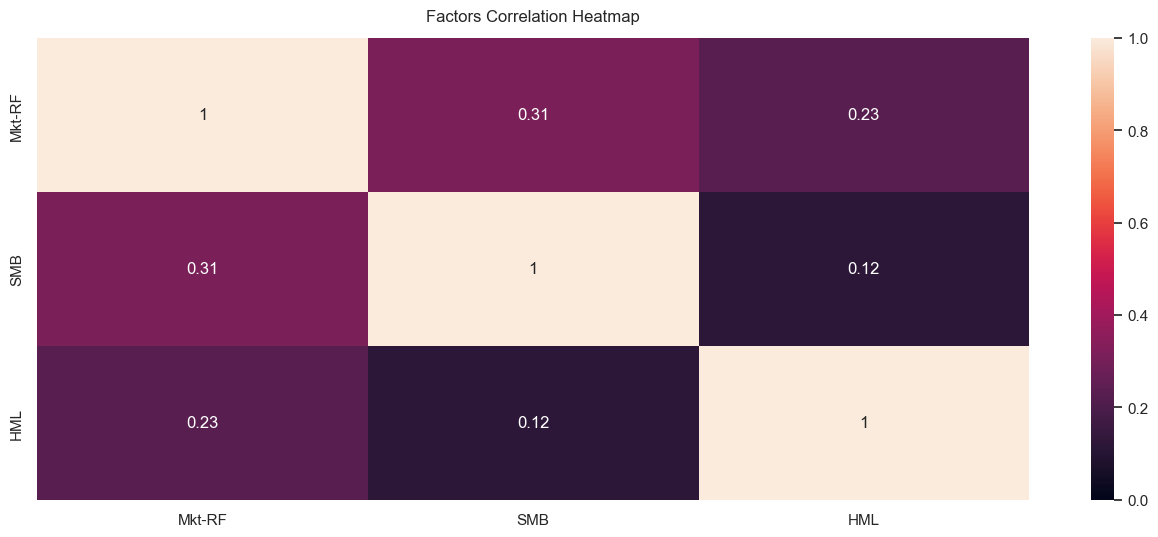

In [44]:
factor_corr = factors.corr()

plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(factor_corr, vmin=0, vmax=1, annot=True)
heatmap.set_title('Factors Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

### Does it achieve this in each subsample?

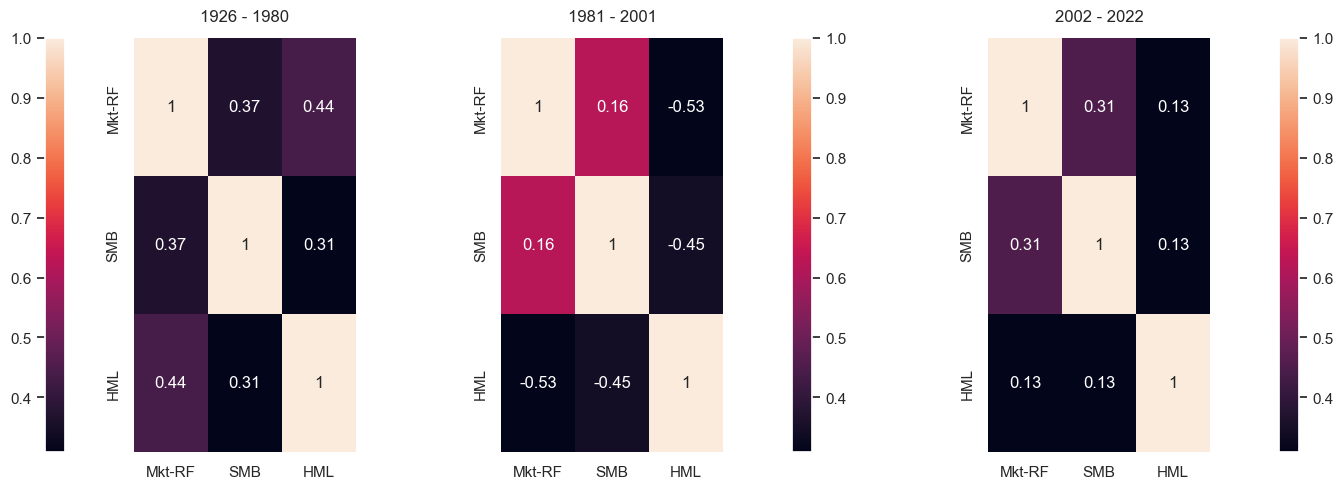

In [45]:
fig, (ax,ax2,ax3) = plt.subplots(ncols=3)

fig.subplots_adjust(wspace=0.01)
fig.tight_layout(pad=1)
sns.heatmap(sub_1980.corr(), ax=ax, cbar=False, annot = True).set_title('1926 - 1980', fontdict={'fontsize':12}, pad=12);

fig.colorbar(ax.collections[0], ax=ax,location="left", use_gridspec=False, pad=0.2)
sns.heatmap(sub_2001.corr(), ax=ax2, cbar=False, annot = True).set_title('1981 - 2001', fontdict={'fontsize':12}, pad=12);

fig.colorbar(ax.collections[0],ax=ax2,location="right", use_gridspec=False, pad=0.2)

sns.heatmap(sub_2022.corr(), ax=ax3, cbar=False, annot = True).set_title('2002 - 2022', fontdict={'fontsize':12}, pad=12);
fig.colorbar(ax.collections[0],ax=ax3,location="right", use_gridspec=False, pad=0.2)

fig.set_figwidth(15)
plt.show()

### 2.4) Plot the cumulative returns of the three factors. Create plots for the 1981-2001 subsample as well as the 2002-Present subsample.

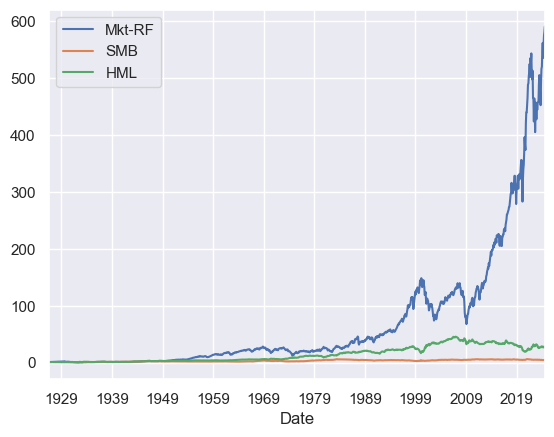

<Figure size 10000x600 with 0 Axes>

In [46]:
figure = ((factors + 1).cumprod()).plot()
plt.figure(figsize=(100, 6))
plt.show()

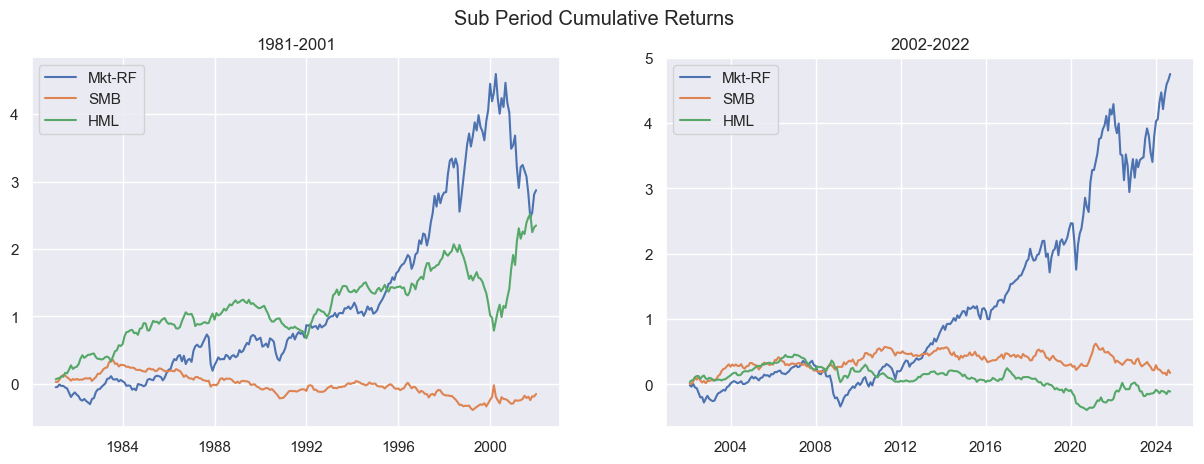

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Sub Period Cumulative Returns')
ax1.plot(((sub_2001 + 1).cumprod() - 1))
ax2.plot(((sub_2022 + 1).cumprod() - 1))

fig.set_figwidth(15)
ax1.legend(sub_2001.columns)
ax2.legend(sub_2022.columns)

ax1.title.set_text('1981-2001')
ax2.title.set_text('2002-2022')

### 2.5) Does it appear that all three factors were valuable in 1981-2001? And post-2001? Would you advise DFA to continue emphasizing all three factors?

As per the graphs above, it appears that the market risk factor was valuable in both sub-samples. However, the Market Factor sees a steep decline with the Tech bubble burst in late 2001, during which time the value factor benefits from the depressed stock prices to post a premium. The Size factor posts near zero or negative returns for the entire sub-sample of 1981-2001. 

With a good recovery post the Tech Bubble burst and similar bull run post the 2008 financial crisis, the Market-factor significantly outperforms Size and Value in the 2002-2022 sub-sample. Both Size and Value factor post meagre returns during this period, with the value factor experiencing declining premiums as companies traded further away from their fundamentals. This Value factor might still be beneficial given its diversification effects.

Though all 3 factors still possess some relevant characterisitics, it appears that Factor rotation might be a better strategy in hindsight. The size factor seems our of favor for a long time now and the returns seem correlated to the Market Factor. DFA should also try to explore other factors such as volatility, liquidity, momentum etc. to generate alpha while sticking to their belief of capital markets being efficient.

## 3. CAPM

#### DFA believes that premia in stocks and stock portfolios is related to the three factors. Let's test 25 equity portfolios that span a wide range of size and value measures

- #### PORTFOLIOS: Monthly total return data on 25 equity portfolios sorted by their size-value characteristics. Denote these as $r^{i}$, for n = 1,....,25.
- #### Note that while the factors were given as excess returns, the portfolios are total returns.
- #### For this entire problem, focus on the 1981-Present subsample.

### 3.1) Summary Statistics.

### For each portfolio,

- ### Use the Risk-Free rate column in the factors tab to convert these total returns to excess returns.
- ### Calculate the (annualized) univariate statistics from 1.1.

In [48]:
port_summary = performance_summary(portfolio_excess_returns.loc['1981-01-01':])
port_summary.loc[:,['Mean','Volatility','Sharpe Ratio','VaR (0.05)']]

,Mean,Volatility,Sharpe Ratio,VaR (0.05)
SMALL LoBM,0.006671,0.273771,0.024366,-0.126059
ME1 BM2,0.088689,0.236403,0.375163,-0.094747
ME1 BM3,0.092006,0.201252,0.457170,-0.086227
ME1 BM4,0.115998,0.194270,0.597099,-0.076972
SMALL HiBM,0.127838,0.210037,0.608646,-0.088535
ME2 BM1,0.058868,0.245156,0.240125,-0.104096
ME2 BM2,0.100515,0.205528,0.489059,-0.085661
ME2 BM3,0.105946,0.185777,0.570288,-0.078490
ME2 BM4,0.108835,0.182098,0.597670,-0.076138
ME2 BM5,0.115994,0.215616,0.537967,-0.096398


### Can the difference in mean excess returns of the portfolios be explained by differences in their volatilities? Or by their VaR(.05) statistics?

Based on the scatter plots below, we do not get a clear indication if the differences in the mean excess returns are explained by differences in either their VaR or their Volatility. Given VaR is a factor of portfolios volatility, more the volatility deeper the VaR threshold, the return differences might be explained slightly by the differences in the volatility. A linear pattern can be observed between volatility and mean excess returns to support the previous arguments, but the evidence is not very concrete from the plots below.

Text(0, 0.5, 'Mean Excess Returns')

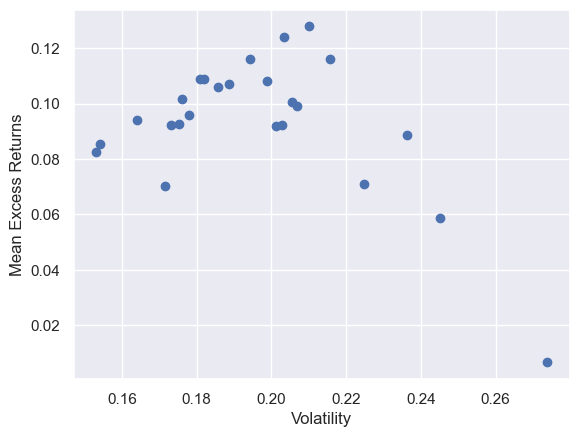

In [49]:
plt.scatter(port_summary.loc[:,['Volatility']],port_summary.loc[:,['Mean']])
plt.xlabel("Volatility")
plt.ylabel("Mean Excess Returns")

Text(0, 0.5, 'Mean Excess Returns')

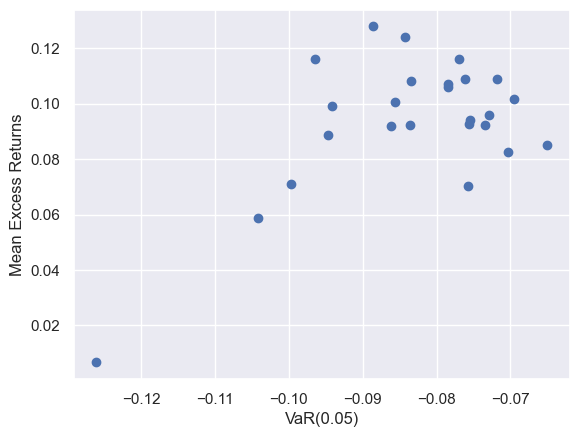

In [50]:
plt.scatter( port_summary.loc[:,['VaR (0.05)']],port_summary.loc[:,['Mean']])
plt.xlabel("VaR(0.05)")
plt.ylabel("Mean Excess Returns")

### 3.2 CAPM

#### The Capital Asset Pricing Model (CAPM) asserts that an asset (or portfolio's) expected excess return is completely a function of its beta to the equity market index (SPY, or in this case, MKT.)
#### Specifically, it asserts that, for any excess return, $\tilde{r}^{i}$, its mean is proportional to the mean excess return of the market, $\tilde{r}^{m}$, where the proporitonality is the regression beta of $\tilde{r}^{i}$ on $\tilde{r}^{m}$.

#### <center>$\mathop{\mathbb{E}}[\tilde{r}^{i}_{t}] = \beta \mathop{\mathbb{E}}[\tilde{r}^{m}_{t}]$</center>
#### Let's examine whether that seems plausible.

### 3.2.a) For each of the n = 25 test portfolios, run the CAPM time-series regression: <br> 
###   <center> $\tilde{r}_{t}^{i}$ = $α^{i} + β^{i,m}\tilde{r}^{m}_{t} + ε_{t}$ </center>
### So you are running 25 separate regressions, each using the T-sized sample of time-series data.

In [51]:
ts_CAPM = time_series_regression(portfolio_excess_returns.loc['1981':], factors.loc['1981':,'Mkt-RF'])

In [52]:
ts_CAPM

,alpha_hat,beta_mkt,info_ratio,treynor_ratio,R-squared,Tracking Error
SMALL LoBM,-0.106730,1.356365,-0.613409,0.004918,0.596078,0.173994
ME1 BM2,-0.008774,1.165744,-0.057999,0.076080,0.590508,0.151278
ME1 BM3,0.004620,1.045218,0.039081,0.088026,0.655026,0.118204
ME1 BM4,0.034696,0.972450,0.285425,0.119285,0.608481,0.121558
SMALL HiBM,0.044652,0.994979,0.315148,0.128483,0.544955,0.141685
ME2 BM1,-0.053049,1.338627,-0.411917,0.043976,0.724033,0.128787
ME2 BM2,0.005631,1.134902,0.053775,0.088568,0.740451,0.104708
ME2 BM3,0.019949,1.028607,0.212415,0.103000,0.744454,0.093913
ME2 BM4,0.027344,0.974696,0.272232,0.111660,0.695744,0.100444
ME2 BM5,0.022822,1.114415,0.178588,0.104085,0.648719,0.127793


### 3.2.b) Report the mean-absolute-erro


In [60]:
abs(ts_CAPM['alpha_hat']).mean()

0.022428026900773772

### If CAPM were true, what would be true of the Treynor Ratios, alphas, and Information Ratios?

If CAPM holds true, all αishould be close to zero.
Consequently, in an ideal scenario, the expected value of MAE should also approach zero.
While the outcome of MAE is approximately 2.24%, which indicates that CAPM may not fully explain the excess returns of the portfolios. A non-zero MAE suggests the presence of significant unexplained returns (alpha) in the model, meaning that factors other than the market return could be influencing the performance of these portfolios. This result implies potential limitations of CAPM, and suggests that additional factors or alternative models might be necessary to better capture the drivers of excess returns..

### (c)

In [ ]:
ts_CAPM

,alpha_hat,beta_mkt,info_ratio,treynor_ratio,R-squared,Tracking Error
SMALL LoBM,-0.106730,1.356365,-0.613409,0.004918,0.596078,0.173994
ME1 BM2,-0.008774,1.165744,-0.057999,0.076080,0.590508,0.151278
ME1 BM3,0.004620,1.045218,0.039081,0.088026,0.655026,0.118204
ME1 BM4,0.034696,0.972450,0.285425,0.119285,0.608481,0.121558
SMALL HiBM,0.044652,0.994979,0.315148,0.128483,0.544955,0.141685
ME2 BM1,-0.053049,1.338627,-0.411917,0.043976,0.724033,0.128787
ME2 BM2,0.005631,1.134902,0.053775,0.088568,0.740451,0.104708
ME2 BM3,0.019949,1.028607,0.212415,0.103000,0.744454,0.093913
ME2 BM4,0.027344,0.974696,0.272232,0.111660,0.695744,0.100444
ME2 BM5,0.022822,1.114415,0.178588,0.104085,0.648719,0.127793


### (d)
If CAPM were valid, we would expect to see the **same** Treynor ratios across all 25 portfolios, as portfolio returns should be entirely driven by market returns (SPY). However, the observed Treynor ratios vary significantly across portfolios, suggesting the presence of high alpha and/or low regression beta.

Similarly, the alphas should have been much lower (ideally 0) for all portfolios, and we would expect the residuals to be smaller in absolute terms, leading to lower (ideally 0) information ratios. Instead, we find that the alphas are higher than expected, and the information ratios are also elevated, pointing to the possibility of other explanatory factors that should be included in the model.

## 3.3) Cross-sectional Estimation

#### Let's test (CAPM) directly. We already have what we need:

- #### The dependent variable, (y): mean excess returns from each of the n = 25 portfolios.
- #### The regressor, (x): the market beta from each of the n = 25 time-series regressions.

- #### Then we can estimate the following equation:

<center> $  \underbrace{\mathop{\mathbb{E}}[\tilde{r}^{i}]}_\text{n x 1 data} = 
    \underbrace{\eta}_\text{regression intercept} +
    \underbrace{\beta^{i,m}}_\text{n x 1 data} *\underbrace{\lambda_{m}}_\text{regression estimate} + \underbrace{\upsilon}_\text{n x 1 residuals}
 $ </center>
 
- #### Note that we use sample means as estimates of $\mathop{\mathbb{E}}[\tilde{r}^{i}]$.
- #### This is a weird regression! The regressors are the betas from the time-series regressions we already ran!
- #### This is a single regression, where we are combining evidence across all n = 25 series. Thus, it is a cross-sectional regression!
- #### The notation is trying to emphasize that the intercept is different than the time-series $\alpha$ and that the regressor coefficient is different than the time-series betas.

### 3.2.a) Report the R-squared of this regression.
### 3.2.b) Report the intercept, $\upsilon$.
### 3.2.c) Report the regression coefficient, $\lambda_{m}$.

In [53]:
portfolio = portfolio_excess_returns.loc['1981':].mean().to_frame('Mean Portfolio excess returns')

In [54]:
time_series_regression(portfolio, ts_CAPM['beta_mkt'])

,alpha_hat,beta_mkt,info_ratio,treynor_ratio,R-squared,Tracking Error
Mean Portfolio excess returns,0.208623,-0.009015,35.404667,-10.4114,0.300557,0.005893


###  What would these three statistics be if (CAPM) were true?

Low alpha: If CAPM holds, all excess returns of the asset should be explained by its market risk premium (beta). Alpha represents excess returns not explained by the market factor. If CAPM is entirely accurate, then this excess return should be close to zero because the market factor has accounted for all systematic risk returns.

High beta: CAPM assumes that the risk premium of an asset is only related to its exposure to market risk. Therefore, the beta coefficient (i.e., the sensitivity of the asset relative to market fluctuations) should be the main explanatory variable and should be high. This reflects the strong correlation between asset returns and the market.

High R-squared: CAPM assumes that the market factor explains all systematic risks and returns of assets. Thus, when regressing portfolio excess returns against the market factor, the R-squared value should be high. This means the market factor has strong explanatory power for returns, and the goodness-of-fit of the regression model is high.

High correlation between market betas: If CAPM holds, all assets’ returns are determined by the market factor (SPY), and their market betas should be similar since they all rely on the same source of systematic risk. This would lead to a high correlation among market betas of assets.


### 3.4) Broadly speaking, do these results support DFA's belief in size and value portfolios containing premia unrelated to the CAPM?

Low R-Squared and Betas and higher alpha from the cross-sectional regression in the previous question, indicat the presence of other risk factors in the market that can explain excess returns of equity portfolios. Also, as shown by the Fama-French paper, size and value have posted premiums in the past and thus can be used to explain mean excess returns in better capacity than CAPM alone. These results do support DFA's belief in size and value portfolios containing premia unrelated to CAPM.

Using Size and Value as additional factors in the regression for the 25 portfolios, we see a higher R-Squared in the regression, further strengthening DFA's belief in existence of premia in Value and Size Factors

# 4) Extensions

### 4.1) Re-do the analysis of 3.3 and 3.3, but instead of using the market return as the factor, use a new factor: the in-sample tangency portfolio of the n = 25 portfolios.

#### You will not use the factor data for this problem!
- #### Calculate $\tilde{r}^{tan}$ by solving the MV optimization of the n excess returns.
- #### Consider this to be your single factor.

#### Instead of testing (CAPM), you will test the MV model:

#### <center>$\mathop{\mathbb{E}}[\tilde{r}^{i}_{t}] = \beta^{i,tan} \mathop{\mathbb{E}}[\tilde{r}^{tan}_{t}]$</center> 

#### What do you find?

In [69]:
portfolio_excess_returns = portfolio_excess_returns.loc['1981':]

In [70]:
# calculate tangency portfolio
def tangency_portfolio(data, cov_mat=1, annual_factor=12):
    if cov_mat == 1:
        cov_inv = np.linalg.inv(data.cov()*annual_factor)
    else:
        cov = data.cov()
        covmat_diag = np.diag(np.diag(cov))
        covmat = cov_mat * cov + (1-cov_mat) * covmat_diag
        cov_inv = np.linalg.inv(covmat*annual_factor)
    
    ones = np.ones(data.columns.shape)
    mean_return = data.mean() * annual_factor

    tangency_weight = cov_inv @ mean_return / (np.transpose(ones) @ cov_inv @ mean_return)
    return tangency_weight

tangency_weight = tangency_portfolio(portfolio_excess_returns, cov_mat=1, annual_factor=12)
wtan = pd.DataFrame(tangency_weight, index=portfolio_excess_returns.columns, columns=['tangency_weight'])
wtan

,tangency_weight
SMALL LoBM,-2.122527
ME1 BM2,0.714753
ME1 BM3,0.174133
ME1 BM4,1.149019
SMALL HiBM,0.948036
ME2 BM1,-0.386376
ME2 BM2,0.906110
ME2 BM3,0.176695
ME2 BM4,-0.214854
ME2 BM5,-0.813314


In [71]:
# calculate tangency returns
tangency_return = portfolio_excess_returns @ wtan
tangency_return

,tangency_weight
Date,
1981-01-31,0.044056
1981-02-28,0.055052
1981-03-31,0.113298
1981-04-30,0.013588
1981-05-31,-0.028835
...,...
2024-04-30,0.025892
2024-05-31,-0.031765
2024-06-30,0.092400


In [72]:
tan_regression_result = time_series_regression(portfolio_excess_returns.loc['1981':], tangency_return.loc['1981':])
tan_regression_result

,alpha_hat,beta_mkt,info_ratio,treynor_ratio,R-squared,Tracking Error
SMALL LoBM,1.082467e-15,0.017416,3.954267e-15,0.383026,0.000174,0.273747
ME1 BM2,7.806256e-16,0.231549,3.372474e-15,0.383026,0.041297,0.231470
ME1 BM3,9.133319e-16,0.240209,4.684161e-15,0.383026,0.061325,0.194983
ME1 BM4,1.334870e-15,0.302847,7.261518e-15,0.383026,0.104610,0.183828
SMALL HiBM,9.029236e-16,0.333758,4.553471e-15,0.383026,0.108695,0.198293
ME2 BM1,6.609296e-16,0.153692,2.719058e-15,0.383026,0.016918,0.243073
ME2 BM2,8.092485e-16,0.262425,4.083290e-15,0.383026,0.070178,0.198185
ME2 BM3,5.737598e-16,0.276604,3.247255e-15,0.383026,0.095427,0.176691
ME2 BM4,6.362098e-16,0.284144,3.692639e-15,0.383026,0.104810,0.172291
ME2 BM5,1.576864e-15,0.302836,7.645110e-15,0.383026,0.084917,0.206258


- Alpha: The positive Alpha suggests that, even with the tangency portfolio as the sole factor, the portfolio still has unexplained excess returns. This may indicate the presence of other risk factors (such as momentum, volatility, etc.) that could better explain the returns.
- Market Beta: The relatively low Beta indicates that the portfolio exhibits lower volatility, with only moderate sensitivity to the tangency portfolio, yet it still manages to generate favorable returns.
- Treynor Ratio and Information Ratio are both strong, highlighting that the portfolio is efficiently utilizing its market exposure to generate returns, and its active risk management strategy is yielding positive outcomes.

### 4.2) Re-do the analysis of 3.3 and 3.4, but instead of using the market return as the factor, use all three factors, (MKT, SMB, and HML). Note again that all three are already given as excess returns, so there is no need to use the risk-free rate data.
### Thus, instead of testing (CAPM), you will be testing the Fama-French 3-Factor Model.

#### <center>$\mathop{\mathbb{E}}[\tilde{r}^{i}_{t}] = \beta^{i,m} \mathop{\mathbb{E}}[\tilde{r}^{m}_{t}] +  \beta^{i,s} \mathop{\mathbb{E}}[\tilde{r}^{s}_{t}] +  \beta^{i,v} \mathop{\mathbb{E}}[\tilde{r}^{v}_{t}]$</center>

In [73]:
regression_result_fama = time_series_regression(portfolio_excess_returns.loc['1981':], factors.loc['1981':],True)
regression_result_fama

,alpha_hat,beta_mkt,Size beta,Value beta,info_ratio,treynor_ratio,R-squared,Tracking Error
SMALL LoBM,-0.085811,1.111846,1.392517,-0.253788,-0.937530,0.006000,0.888226,0.091529
ME1 BM2,0.001435,0.965456,1.317675,-0.014432,0.020344,0.091863,0.910924,0.070556
ME1 BM3,0.000595,0.923142,1.065113,0.277445,0.011988,0.099666,0.939265,0.049597
ME1 BM4,0.022184,0.877818,1.065753,0.477399,0.467283,0.132144,0.940281,0.047474
SMALL HiBM,0.023053,0.929787,1.066006,0.691417,0.312014,0.137492,0.876254,0.073886
ME2 BM1,-0.032422,1.141897,1.023281,-0.310250,-0.539477,0.051553,0.939904,0.060099
ME2 BM2,0.007150,1.013778,0.915858,0.121287,0.141210,0.099149,0.939304,0.050635
ME2 BM3,0.008658,0.973977,0.719244,0.389224,0.165561,0.108777,0.920763,0.052295
ME2 BM4,0.008373,0.941288,0.748332,0.575080,0.186100,0.115623,0.938957,0.044991
ME2 BM5,-0.005771,1.089194,0.929779,0.832768,-0.124297,0.106495,0.953637,0.046426


## 3.
### (a)

### 4.3.b) Under classic statistical assumptions, we can test the null hypothesis that the CAPM works by calculating,

### <center> $\text{H} = \text{T} \ [1+(\text{SR}_{m})^{2}]^{-1} \alpha^{'}\Sigma^{-1}_{\epsilon}\alpha ~ \chi^{2}_{n}$ </center>

- ### Note the following:
- ### $\alpha$ is an n x 1 vector of the individual regression alphas, $\alpha^{i}$.
- ### $\Sigma_{\epsilon}$ is the n x n covariance matrix of the time-series of regression residuals, $\epsilon^{i}$, corresponding to each regression.
- ### $\text{SR}_{m}$ is the Sharpe-Ratio of $\tilde{r}^{m}$.

### The test statistic, H, has a chi-squared distribution with n = 25 degrees of freedom. So under the null hypothesis of the CAPM holding, H should be small, and the distribution allows us to calculate the probability of seeing such a large H, conditional on the CAPM being true.

In [74]:
resid = time_series_regression(portfolio_excess_returns.loc['1981':], factors.loc['1981':,'Mkt-RF'], False, True)

In [75]:
T = portfolio_excess_returns['1981':].shape[0]
SR = factors['1981':]['Mkt-RF'].mean() *12/ factors['1981':]['Mkt-RF'].std()*np.sqrt(12)
Sigma = resid.cov()
Sigma_inv = pd.DataFrame(np.linalg.inv(Sigma), index=Sigma.index, columns=Sigma.columns)
alpha = ts_CAPM['alpha_hat']

H = T * (1 + SR**2)**(-1) * (alpha @ Sigma_inv @ alpha)

print('H = {:.2f}'.format(H))
pvalue = 1 - stats.chi2.cdf(H, df=25)
print('p-value = {:.4f}'.format(pvalue))

H = 472.07
p-value = 0.0000


### 4.3.c) Which is a stricter test: checking whether any of the n values of $\alpha^{i}$ have a statistically significant t-test or checking whether H calculated above is significant?

- By definition, a joint test is stricter than testing the conditions individually.

- In our case, we can see that most of the alphas (20 alphas) are not significant (as -value  0.05) while 5 alphas are signficant (as -value  0.05) as judged by their individual -stats, yet all of them are jointly significant as judged by this joint test.

### 4.3.d) Conceptually, how does the test-statistic H relate to checking whether $\tilde{r}^{m}$ spans the tangency portfolio?

- We have demonstrated that an LFM is exactly the same as asserting that a set of factors spans the MV frontier, (and thus spans the tangency portfolio.) 
- Thus, this test can be interpreted as checking whether investing in the alphas gets beyond the tangency portfolio. The test stat is basically comparing the square SR of the alphas to the square SR of the factors.